TS decompose

In [1]:
a<- ts(1:30,frequency=12,start=c(2011,3))

In [3]:
sta<- ts(1:30,frequency=12,start=c(2011,3))r(a)

 Time-Series [1:30] from 2011 to 2014: 1 2 3 4 5 6 7 8 9 10 ...


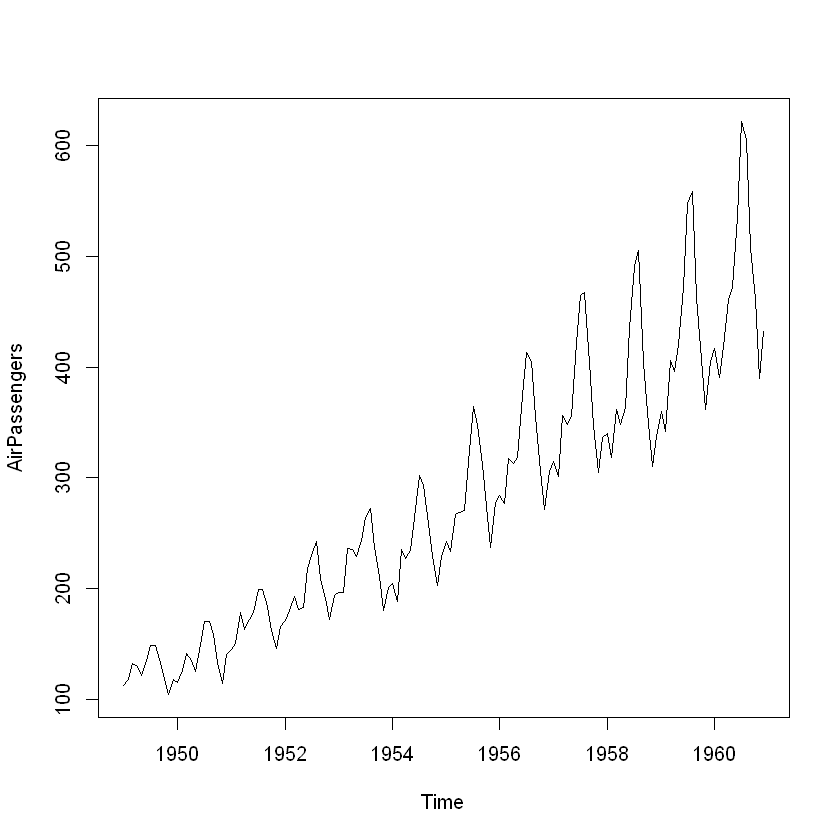

In [4]:
plot(AirPassengers)

In [7]:
apts<-ts(AirPassengers,frequency=12)
f<-decompose(apts)

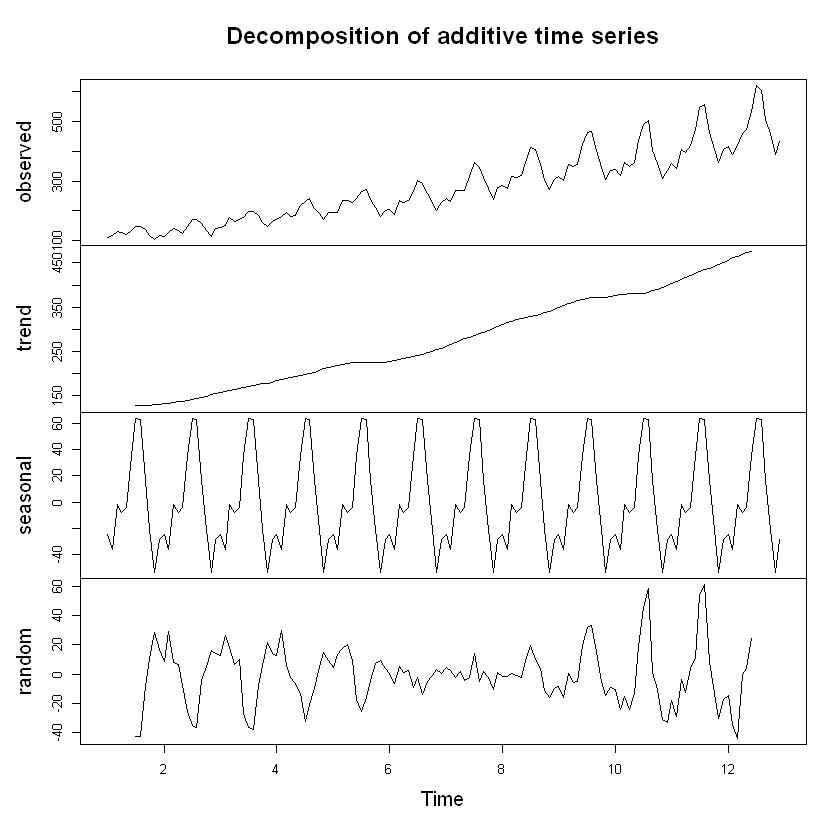

In [9]:
plot(f)

In [27]:
str(AirPassengers)

 Time-Series [1:144] from 1949 to 1961: 112 118 132 129 121 135 148 148 136 119 ...


TS predict

In [29]:
fit <- arima(AirPassengers,order=c(1,0,0),list(order=c(2,1,0),period=12))

In [30]:
fore <- predict(fit,n.ahead=24)
U<-fore$pred + 2*fore$se
L<-fore$pred - 2*fore$se

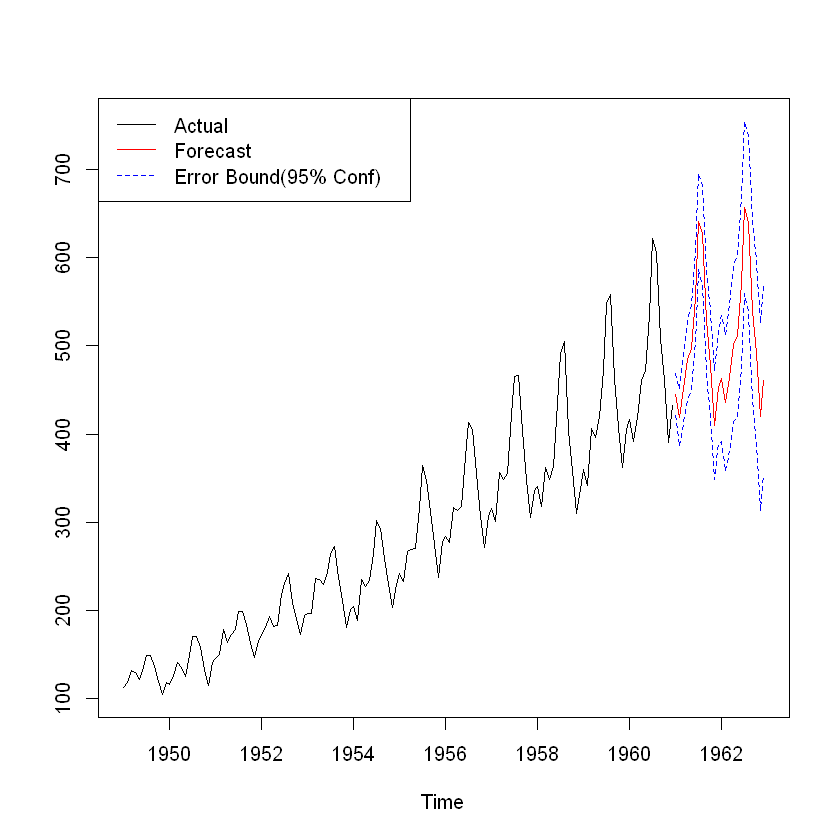

In [34]:
ts.plot(AirPassengers,fore$pred,U,L,col=c(1,2,4,4),lty=c(1,1,2,2))
legend("topleft",c("Actual","Forecast","Error Bound(95% Conf)"),col=c(1,2,4),lty=c(1,1,2))

distance - Euclidean vs DTW (Dynamic Time Warping)

In [39]:
library(dtw)

Loading required package: proxy

Attaching package: 'proxy'

The following objects are masked from 'package:stats':

    as.dist, dist

The following object is masked from 'package:base':

    as.matrix

Loaded dtw v1.20-1. See ?dtw for help, citation("dtw") for use in publication.



In [40]:
idx<-seq(0,2*pi,len=100)
a<- sin(idx)+runif(100)/10
b<- cos(idx)
align<-dtw(a,b,step=asymmetricP1,keep=T)

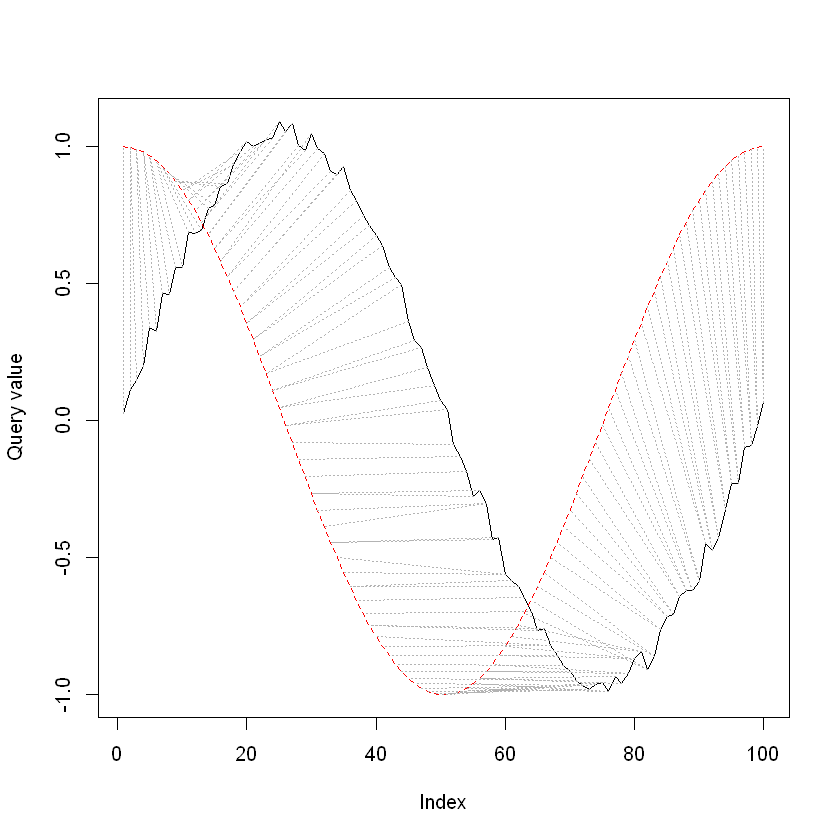

In [49]:
dtwPlotTwoWay(align)

In [53]:
align$distance

[1] 32.62775

Clustering

In [5]:
#sc<-read.table("synthetic_control.txt",header = F,sep=" ",fill=T)
sc<-read.csv("synthetic_control.csv",header = F)

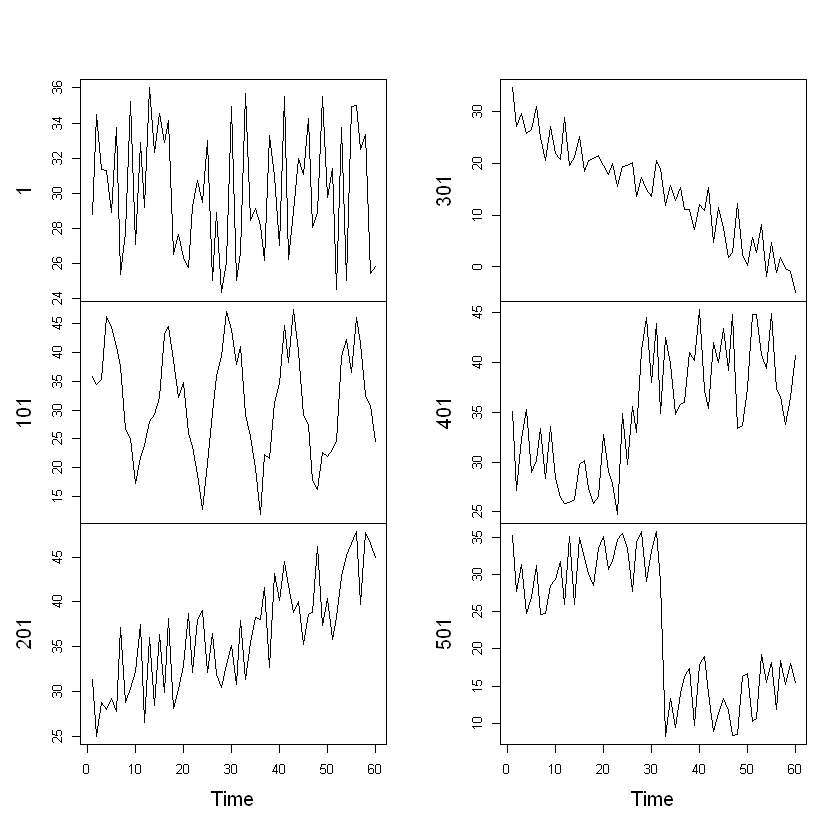

In [9]:
idx<-c(1,101,201,301,401,501)
sample1<-t(sc[idx,])
plot.ts(sample1,main="")

In [45]:
set.seed(1234)
n<-10
s<-sample(1:100,n)
idx<-c(1+s,100+s,200+s,300+s,400+s,500+s)

In [46]:
sample2<-sc[idx,]
observedLabels<-rep(1:6,each=n)

In [21]:
library(dtw)

Loading required package: proxy

Attaching package: 'proxy'

The following objects are masked from 'package:stats':

    as.dist, dist

The following object is masked from 'package:base':

    as.matrix

Loaded dtw v1.20-1. See ?dtw for help, citation("dtw") for use in publication.



In [48]:
distmatrix<- dist(sample2,method="DTW")
hc2<-hclust(distmatrix,method="average")

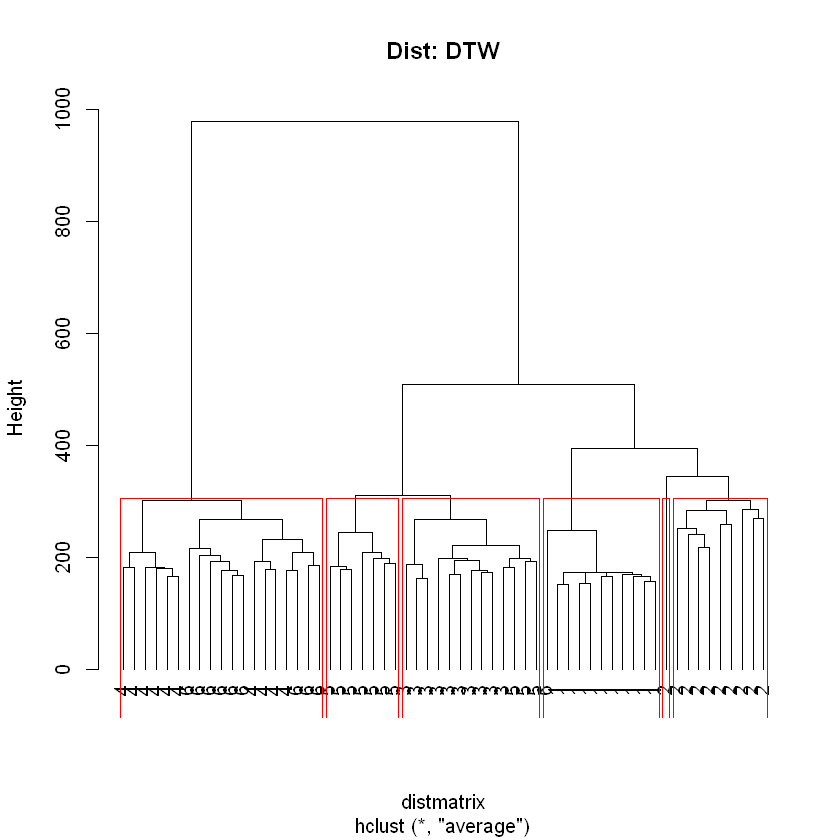

In [50]:
plot(hc2,hang=-1,main="Dist: DTW",labels=observedLabels)
rect.hclust(hc2,k=6)

In [52]:
memb <- cutree(hc2,k=6)
table(observedLabels,memb)

              memb
observedLabels  1  2  3  4  5  6
             1 10  0  0  0  0  0
             2  0  9  1  0  0  0
             3  0  0  0 10  0  0
             4  0  0  0  0 10  0
             5  0  0  0  3  0  7
             6  1  0  0  0  9  0

In [60]:
hc<-hclust(dist(sample2),method="average")

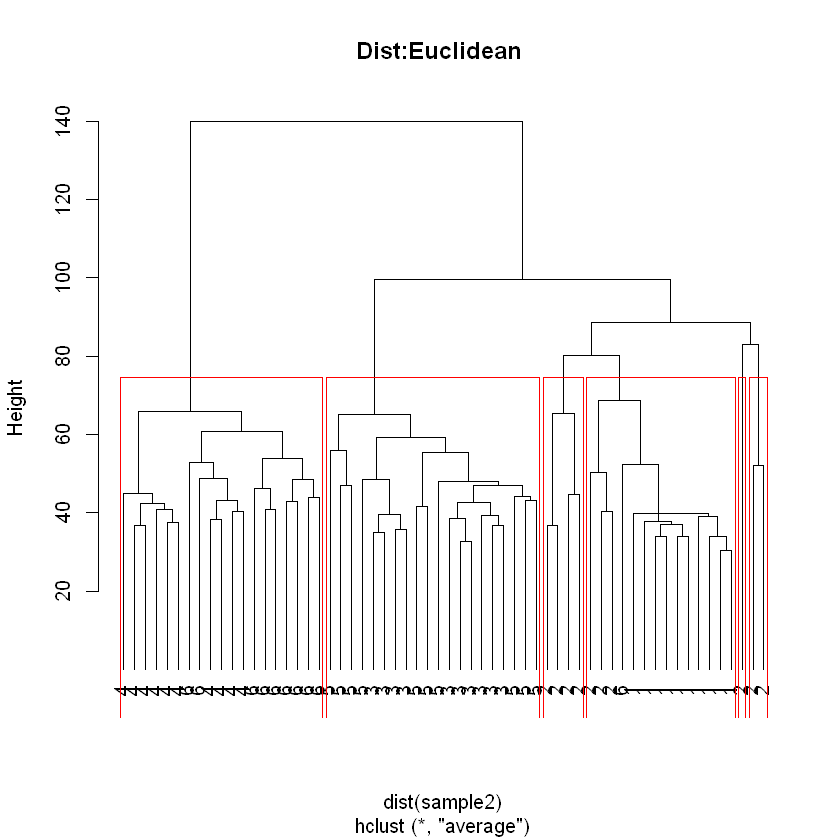

In [73]:
plot(hc,main="Dist:Euclidean ",hang=-1,labels=observedLabels)
rect.hclust(hc,k=6)

In [66]:
memb<-cutree(hc,6)
table(observedLabels,memb)

              memb
observedLabels  1  2  3  4  5  6
             1 10  0  0  0  0  0
             2  3  4  1  2  0  0
             3  0  0  0  0 10  0
             4  0  0  0  0  0 10
             5  0  0  0  0 10  0
             6  1  0  0  0  0  9

Classification - DWT

In [99]:
classId<-rep(as.character(1:6),each=100)
newsc<-data.frame(cbind(classId,sc))

In [105]:
library(party)
ct<-ctree(classId~.,data=newsc,controls=ctree_control(minsplit=30,minbucket=10,maxdepth=5))
pClassId<-predict(ct)
table(classId,pClassId)

       pClassId
classId   1   2   3   4   5   6
      1  97   0   0   0   0   3
      2   1  93   2   0   0   4
      3   0   0  96   0   4   0
      4   0   0   0 100   0   0
      5   4   0  10   0  86   0
      6   0   0   0  87   0  13

In [106]:
accu<-(sum(pClassId==classId))/nrow(sc)

In [107]:
accu

[1] 0.8083333

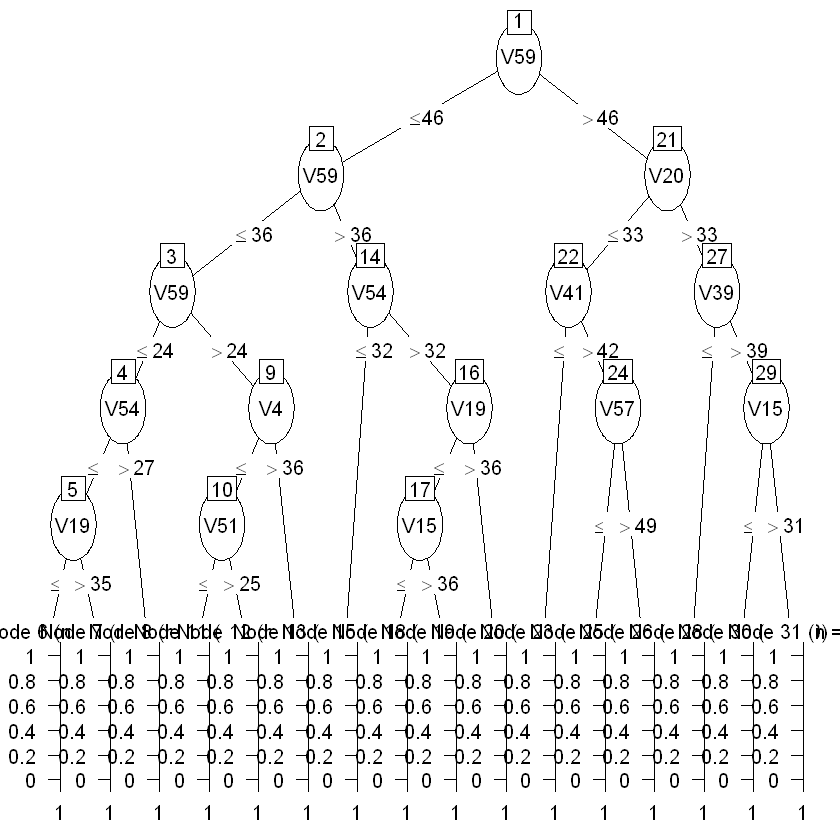

In [147]:
plot(ct,ip_args=list(pval=F),ep_args=list(digits=0),cex=0.2)

In [101]:
#DWT
library(wavelets)

In [102]:
wtData <- NULL
for (i in 1:nrow(sc)){
    a <- t(sc[i,])
    wt <- dwt(a,filter="haar",boundary="periodic")
    wtData<-rbind(wtData,unlist(c(wt@W,wt@V[[wt@level]])))
}
wtData <- as.data.frame(wtData)
wtSc <- data.frame(cbind(classId,wtData))
ct <- ctree(classId~.,data=wtSc,controls=ctree_control(minsplit=30,minbucket=10,maxdepth=5))
pClassId<- predict(ct)
table(classId,pClassId)

       pClassId
classId  1  2  3  4  5  6
      1 97  3  0  0  0  0
      2  1 99  0  0  0  0
      3  0  0 81  0 19  0
      4  0  0  0 63  0 37
      5  0  0 16  0 84  0
      6  0  0  0  1  0 99

In [104]:
(sum(classId==pClassId))/nrow(wtSc)

[1] 0.8716667

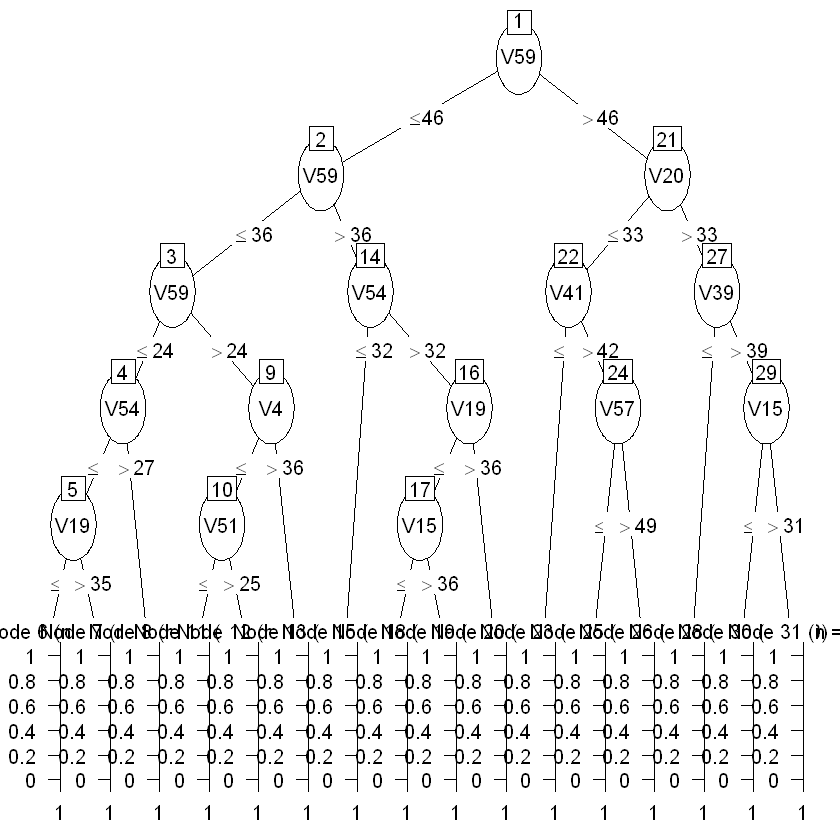

In [108]:
plot(ct,ip_args=list(pval=F),ep_args=list(digits=0))

In [148]:
k <- 20
newTS <- sc[501,] + runif(100)*15
distance <- dist(newTS,sc,method="DTW")
s<-sort(as.vector(distance),index.return=T)
table(classId[s$ix[1:k]])


 2  4  6 
 1  2 17 